In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [4]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/ '
dest_path = 'DFT_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis'


In [3]:
omp = 1
mpi = 16 #4
partition = 'all12h' # debug, slownodes, all12h, fastnode, smallnode
memory = '125000' # 60000 / 125000 / 180000
nodelist = 'wnode08'
ntasks_per_node = '%s'%int(mpi/2)
nodes = 1
sbatch_options = [
    '--partition=%s'%partition,
    '--mem=%s'%memory,
    #'--nodes=%s'%nodes,
    #'--ntasks-per-node=%s'%ntasks_per_node,
    #,'--nodelist=%s'%nodelist
    ] 

In [4]:
#code = C.QeCalculator(omp=omp,mpi=mpi) 
code = C.QeCalculator(omp=omp,mpi=mpi,scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'pw.x',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h', '--mem=125000'],
 'activate_BeeOND': True,
 'verbose': True}

# DFT analysis of the Germanene (monolayer) 

This notebook contains the DFT analysis of the Germanene performed with QuantumESPRESSO. In particular

* GS is computed directly _at convergence_ using the input file from a previous convergence analysis. 
* We analyze the DFT band structure

## Geometric setup

One possibility is to use symmetric lattice vectors around the $x$ axis, with the lattice the zig-zag along the y axis.

In this case we choose the basis vector as:
$$
a_1 = \frac{a_{lat}}{2}(\sqrt{3},1,0) \, ,\quad a_2 = \frac{a_{lat}}{2}(\sqrt{3},-1,0) \, ,\quad
a_3 = (0,0,c)
$$
Here $a_{lat}$ is the lattice parameter and $c$ determines the spacing between the layers. 

The position of the atoms in the lattice is given by (note that the $A$ and $B$ defined in the
formula do _not_ match the labels in the figure):
$$
A = a_{lat}(0,0,\delta) \, \qquad B = a_{lat}(\frac{1}{2\sqrt{3}},\frac{1}{2},-\delta)
$$
where $\delta$ is the buckling parameter (in units of $a_{lat}$). 

The nearest distance (on the plane) between the atoms is equal to $a = \frac{a_{lat}}{\sqrt{3}}$.

The position of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) are given by:
$$
M = (\frac{1}{\sqrt{3}},0) \, \quad
K = (\frac{1}{\sqrt{3}},\frac{1}{3}) 
$$

In [122]:
alat = 1 # arbitrary units
a1 = alat*np.array([np.sqrt(3)/2,1/2])
a2 = alat*np.array([np.sqrt(3)/2,-1/2])
A = alat*np.array([0,0])
#B = alat*np.array([1/(2*np.sqrt(3)),1/2])
B = alat*np.array([1/np.sqrt(3),0])

In [125]:
lattice = pb.Lattice(a1=a1,a2=a2)
lattice.add_sublattices(('A', A), ('B', B))
t=1
lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'B', 'A', t),([1, 0], 'B', 'A', t))
#lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'A', 'B', t))#,([1, 0], 'A', 'B', t))

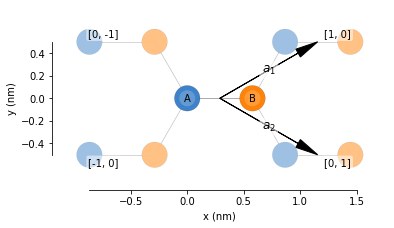

In [126]:
lattice.plot()

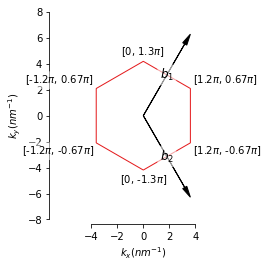

In [127]:
lattice.plot_brillouin_zone()

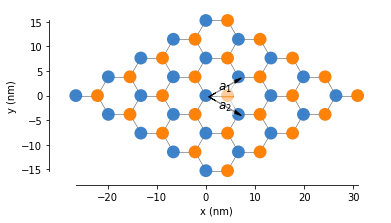

In [49]:
model = pb.Model(lattice,pb.primitive(a1=5, a2=5))
model.plot()
model.lattice.plot_vectors(position=[0.6, -0.25])

Another possibility is to use the geometric setup adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
The atoms are located in 
$$
A = a_{lat}(0,0,\delta) \, \qquad B = a_{lat}(0,\frac{1}{\sqrt{3}},-\delta)
$$
and nearest atomic distance is $a=a_{lat}/\sqrt{3}$ as expected. 
 
In this case the lattice is oriented with the zig-zag along the x axis.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In [128]:
alat = 1 # arbitrary units
a1 = alat*np.array([1,0])
a2 = alat*np.array([-1/2,np.sqrt(3)/2])

In [116]:
A = alat*np.array([0,0])
B = alat*np.array([0,1/np.sqrt(3)])

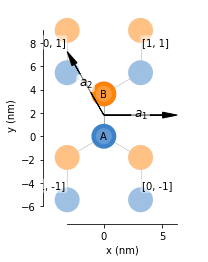

In [119]:
lattice = pb.Lattice(a1=a1,a2=a2)
lattice.add_sublattices(('A', A), ('B', B))
t=1
lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'B', 'A', t),([1, 1], 'B', 'A', t))
lattice.plot()

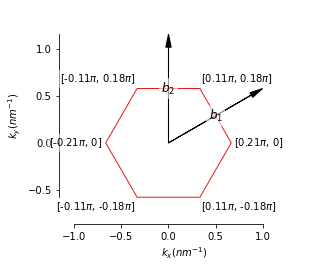

In [120]:
lattice.plot_brillouin_zone()

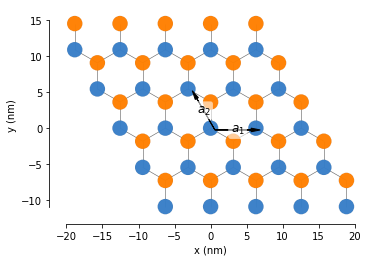

In [121]:
model = pb.Model(lattice,pb.primitive(a1=5, a2=5))
model.plot()
model.lattice.plot_vectors(position=[0.6, -0.25])

## GS Analysis

We use the second geometric setup in which the lattice is defined using the ibrav=4 option of QuantumESPRESSO.

The $a_{lat}$ and $c$ parametes are read from the celldm(1) and celldm(3) values of the original input.

The buckilng parameter $\delta$ is read from the atomic positions of the original input.

In [5]:
alat = 7.643 # in a.u.
c = 4. # 8. # in units of alat
delta = 0.083971326 # in units of alat

We set the atomic positions in the basis defined above (in units of alat)

In [6]:
A = np.array([0,0,delta])
B = np.array([0,1/np.sqrt(3),-delta])

We build the input using the convergence parameters of the original input file.

In [7]:
pseudo = 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF'
pseudo_dir = '../pseudos'
run_dir = 'DFT_analysis'
scf_prefix = 'GS_converged'
ecut_wf = 90 # energy cutoff on the wavefunction (Ry)
kpoints = [12.,12.,1.]

In [8]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6) # needed for the Yambo simulations
inp.set_prefix(scf_prefix)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_energy_cutoff(ecut_wf)
inp.set_spinorbit()
inp.add_atom(atom='Ge',pseudo_name=pseudo,mass=72.64)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=c)
inp.set_kpoints(points = kpoints)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'GS_converged'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ecutwfc': 90,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 7.643,
  'celldm(3)': 4.0},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ge', array([0.        , 0.        , 0.08397133])],
   ['Ge', array([ 0.        ,  0.57735027, -0.08397133])]]},
 'kpoints': {'type': 'automatic',
  'values': ([12.0, 12.0, 1.0], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [9]:
results = code.run(run_dir=run_dir,input=inp,name=scf_prefix)

Skip the run of GS_converged


## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [10]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [13]:
klist = Tools.build_kpath(G,Mp,Kp,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.5773502691896258, 0.0, 30],
 [0.3333333333333333, 0.5773502691896258, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [14]:
inp.set_bands(32,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ecutwfc': 90,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 7.643,
  'celldm(3)': 4.0,
  'nbnd': 32},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ge', array([0.        , 0.        , 0.08397133])],
   ['Ge', array([ 0.        ,  0.57735027, -0.08397133])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.5773502691896258, 0.0, 30],
   [0.3333333333333333, 0.5773502691896258, 0.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [ ]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir=os.path.join(run_dir,scf_prefix)+'.save')

copy source_dir DFT_analysis/GS_converged.save in the /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


In [ ]:
data = P.PwParser(results)

Parse file : /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/bands.save/data-file-schema.xml


In [ ]:
data.get_gap()

Direct gap system
Gap : 0.023027914658062087 eV


{'gap': 0.023027914658062087,
 'direct_gap': 0.023027914658062087,
 'position_cbm': 60,
 'positon_vbm': 60}

This value can be compared with the gap of 0.02366 eV in the celldm(3)=8 case.

Once that the computation is over we can create an instance of PwBands

In [19]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [20]:
bands.get_high_sym_positions()

(['G', 'G', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

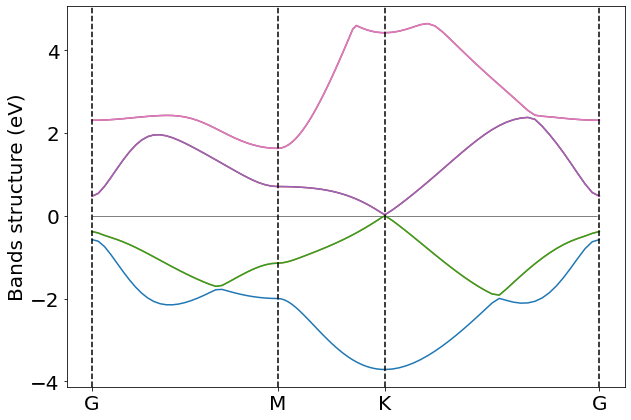

In [21]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(25,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

We plot the bands near the Dirac cone

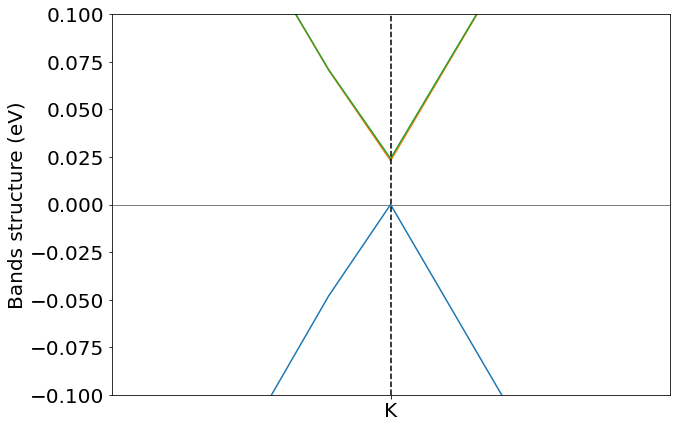

In [22]:
label_size = 20
K_pos = bands.get_high_sym_positions()[1][2]
dk = 0.05

fig, ax = plt.subplots(figsize=(10, 7))
bands.plot(plt,selection=[i for i in range(27,30)])
ax.set_xlim(K_pos-dk,K_pos+dk)
ax.set_ylim(-0.1,0.1)
ax.hlines(0.,0.,1.7,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

The gap is clearly visible.

## NSCF computations on regular grids

We perform NSCF computations on regular grids of various size to study the GW
convergence in function of the number of $k$-points.

We use an high number of empty bands that will be used in the GW analysis.

We write the coordinates of the high symmetry points

In [11]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [12]:
nbnds = 60 #100
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)

In [13]:
#kvalues = [12,15,18,21,24,27,30,36,42,48,54]
kvalues = [12,18,24,30,36,42,48,54,60,66,78]
kvalues

[12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 78]

In [14]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 2 parallel tasks


In [15]:
for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir=os.path.join(run_dir,scf_prefix)+'.save')

In [16]:
#study.runs[0]

In [17]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10]] 

Run the task [0, 1] 
Skip the run of kpoints_12-nbnds_60
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/kpoints_12-nbnds_60.save already exists. Source_dir DFT_analysis/GS_converged.save not copied
Skip the run of kpoints_18-nbnds_60
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/kpoints_18-nbnds_60.save already exists. Source_dir DFT_analysis/GS_converged.save not copied
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of kpoints_24-nbnds_60
Skip the run of The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/kpoints_24-nbnds_60.save already exists. Source_dir DFT_analysis/GS_converged.save not copiedkpoints_30-nbnds_60

The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/kpoints_30-nbnds_60.save already exists

In [53]:
kp = results[7].kpoints # cartesian coordinates in units of 2\pi/alat
#kp

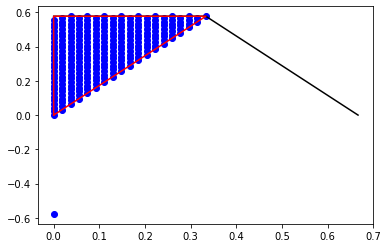

In [54]:
BZ = [K, Kp, Mp]
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

We observe the point $K'$ belongs to the grid for all the dimensions of the
sampling and that it is always the last point of the sampled list.